# Text-to-Image Generation using Stable Diffusion - Homework Assignment

![Stable Diffusion Architecture](https://miro.medium.com/v2/resize:fit:1400/1*NpQ282NJdOfxUsYlwLJplA.png)

In this homework, you will finetune a **Stable Diffusion** model to generate Naruto-style images from text descriptions. This involves working with the complete diffusion pipeline including VAE, UNet, text encoder, and scheduler.

## 📌 Project Overview
- **Task**: Text-to-Naruto image generation
- **Architecture**: Stable Diffusion with UNet diffusion model
- **Dataset**: Naruto-style dataset with text descriptions
- **Goal**: Generate realistic Naruto-style images from text prompts

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand diffusion models and the stable diffusion pipeline
- Learn to finetune pre-trained diffusion models
- Work with VAE, UNet, text encoders, and schedulers
- Practice text-to-image generation techniques
- Handle memory constraints with large models

## 1️⃣ Dataset Setup (PROVIDED)

The Naruto-style dataset has been loaded for you. The dataset contains:
- 1,221 training images with corresponding text descriptions
- Each sample has an 'image' and 'text' field
- Images are in various sizes and need to be resized to 512x512


In [7]:
from datasets import load_dataset

# Dataset already loaded
ds = load_dataset("Alex-0402/naruto-style-dataset-with-text")
print("Dataset info:", ds)
print("Number of training samples:", len(ds['train']))

# Display a sample
sample = ds['train'][0]
print("\nSample text:", sample['text'])
print("Image size:", sample['image'].size)

Dataset info: DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1221
    })
})
Number of training samples: 1221

Sample text: a man with dark hair and brown eyes, naruto style
Image size: (1080, 1080)


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import diffusers, transformers, and related libraries
- Import PyTorch, PIL, numpy, and other utilities
- Set random seeds for reproducibility
- Configure hyperparameters for stable diffusion training

In [9]:
# Cell 4: Import Libraries and Configuration
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from diffusers import AutoencoderKL, PNDMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os

# Set random seeds for reproducibility (use seed=42)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device availability and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define configuration parameters:
IMG_SIZE = 512  # Image size for Stable Diffusion
BATCH_SIZE = 1  # Small batch size due to memory constraints
LEARNING_RATE = 1e-6  # Learning rate for fine-tuning
NUM_EPOCHS = 5  # Number of training epochs
INFERENCE_STEPS = 100  # Steps for inference
GUIDANCE_SCALE = 7.5  # Classifier-free guidance scale
model_id = "OFA-Sys/small-stable-diffusion-v0"

Using device: cuda


## 3️⃣ Load Pre-trained Stable Diffusion Components

**Task**: Load all components of the stable diffusion pipeline.

**Requirements**:
- Load VAE (Variational Autoencoder) for image encoding/decoding
- Load UNet for the diffusion process
- Load text encoder and tokenizer for text conditioning
- Load noise scheduler for the diffusion process


In [10]:
# Cell 7: Load Pretrained Stable Diffusion Components
# Load Stable Diffusion components from model_id
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
tokenizer = CLIPTokenizer.from_pretrained(model_id, subfolder="tokenizer")
scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")

# Move models to device
vae = vae.to(device)
unet = unet.to(device)
text_encoder = text_encoder.to(device)

# Set VAE and text_encoder to eval mode (only fine-tune UNet)
vae.eval()
text_encoder.eval()

# Print model information and parameter counts
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"VAE parameters: {count_parameters(vae):,}")
print(f"UNet parameters: {count_parameters(unet):,}")
print(f"Text Encoder parameters: {count_parameters(text_encoder):,}")

An error occurred while trying to fetch OFA-Sys/small-stable-diffusion-v0: OFA-Sys/small-stable-diffusion-v0 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch OFA-Sys/small-stable-diffusion-v0: OFA-Sys/small-stable-diffusion-v0 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
The config attributes {'predict_epsilon': True} were passed to PNDMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


VAE parameters: 83,653,863
UNet parameters: 579,384,964
Text Encoder parameters: 123,060,480


## 4️⃣ Data Preprocessing and Custom Dataset

**Task**: Create custom dataset class and preprocessing pipeline.

**Requirements**:
- Resize images to 512x512 resolution
- Normalize images to [-1, 1] range for VAE
- Tokenize text descriptions
- Handle data augmentation appropriately

In [11]:
class NarutoDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        text = item['text']

        # Convert PIL image to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)

        return image, text

In [12]:
# Cell 6: Data Preprocessing and Loading
# Define transforms using transforms.Compose
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create train_dataset using NarutoDataset
train_dataset = NarutoDataset(ds['train'], transform=transform)

# Create train_loader with DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for compatibility
)

# Print dataset size
print(f"Dataset size: {len(train_dataset)}")

# Test by loading one sample and printing shapes
sample_image, sample_text = train_dataset[0]
print(f"Sample image shape: {sample_image.shape}")
print(f"Sample text: {sample_text}")

Dataset size: 1221
Sample image shape: torch.Size([3, 512, 512])
Sample text: a man with dark hair and brown eyes, naruto style


## 5️⃣ Training Setup and Loss Function

**Task**: Set up the training components including optimizer and loss function.

**Requirements**:
- Create optimizer for UNet parameters only
- Implement the diffusion loss (noise prediction loss)
- Set up proper gradient scaling and mixed precision if needed
- Configure learning rate scheduling

In [13]:
# Cell 8: Training Setup
# Freeze VAE and text_encoder parameters
for param in vae.parameters():
    param.requires_grad = False
for param in text_encoder.parameters():
    param.requires_grad = False

# Set unet to training mode
unet.train()

# Create optimizer for unet parameters only
optimizer = torch.optim.AdamW(unet.parameters(), lr=LEARNING_RATE)

# Set up noise scheduler for training
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

The config attributes {'predict_epsilon': True} were passed to DDPMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [14]:
# Create helper functions
def encode_text(prompts):
    """Tokenize and encode text prompts"""
    text_inputs = tokenizer(
        prompts,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]
    return text_embeddings

def encode_images(images):
    """Encode images to latent space using VAE"""
    with torch.no_grad():
        latents = vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215  # Scale factor
    return latents

def decode_latents(latents):
    """Decode latents back to images"""
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        images = vae.decode(latents).sample
    return images

## 6️⃣ Training Loop Implementation

**Task**: Implement the main training loop for diffusion model finetuning.

**Requirements**:
- Encode images to latent space using VAE
- Add noise to latents according to diffusion schedule
- Predict noise using UNet conditioned on text
- Compute loss between predicted and actual noise
- Update UNet parameters via backpropagation

In [15]:
# Cell 9: Training Loop
# Track losses
losses = []

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    epoch_losses = []

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_idx, (images, texts) in enumerate(progress_bar):
        # Move images to device
        images = images.to(device)

        # Encode text prompts to get text embeddings
        text_embeddings = encode_text(texts)

        # Encode images to latent space using VAE
        latents = encode_images(images)

        # Sample random timesteps
        timesteps = torch.randint(
            0, noise_scheduler.config.num_train_timesteps,
            (latents.shape[0],), device=device
        ).long()

        # Add noise to latents according to timestep
        noise = torch.randn_like(latents)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise using U-Net with text conditioning
        noise_pred = unet(noisy_latents, timesteps, text_embeddings).sample

        # Calculate MSE loss between predicted and actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Backpropagate and update U-Net parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        epoch_losses.append(loss.item())
        progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        # Clear cache periodically
        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

    avg_loss = np.mean(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} completed. Average Loss: {avg_loss:.4f}")

print("Training completed!")

Starting training...


Epoch 1/3:   0%|          | 1/1221 [00:53<18:00:17, 53.13s/it, Loss=0.1245]


KeyboardInterrupt: 

## 7️⃣ Inference Pipeline Setup

**Task**: Create inference pipeline for text-to-image generation.

**Requirements**:
- Set up complete diffusion pipeline with trained UNet
- Configure scheduler for inference (100 steps)
- Implement text-to-image generation function
- Handle classifier-free guidance

In [16]:
# Set all models to eval mode
unet.eval()
vae.eval()
text_encoder.eval()

def generate_image(prompt, num_inference_steps=INFERENCE_STEPS, guidance_scale=GUIDANCE_SCALE, seed=None):
    """Generate image from text prompt"""
    if seed is not None:
        torch.manual_seed(seed)

    with torch.no_grad():
        # Encode text
        text_embeddings = encode_text([prompt])

        # Generate unconditional embeddings for classifier-free guidance
        uncond_embeddings = encode_text([""])

        # Concatenate for classifier-free guidance
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        # Generate random latent noise
        latents = torch.randn(
            (1, unet.config.in_channels, IMG_SIZE // 8, IMG_SIZE // 8),
            device=device
        )

        # Set up scheduler for inference
        scheduler.set_timesteps(num_inference_steps)
        latents = latents * scheduler.init_noise_sigma

        # Perform denoising
        for t in tqdm(scheduler.timesteps, desc="Generating"):
            # Expand latents for classifier-free guidance
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # Predict noise
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, text_embeddings).sample

            # Classifier-free guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # Compute previous noisy sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        # Decode latents to images
        images = decode_latents(latents)

        # Convert to PIL image
        images = (images / 2 + 0.5).clamp(0, 1)
        images = images.cpu().permute(0, 2, 3, 1).numpy()
        images = (images * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]

        return pil_images[0]

Generating: 100%|██████████| 109/109 [13:34<00:00,  7.47s/it]


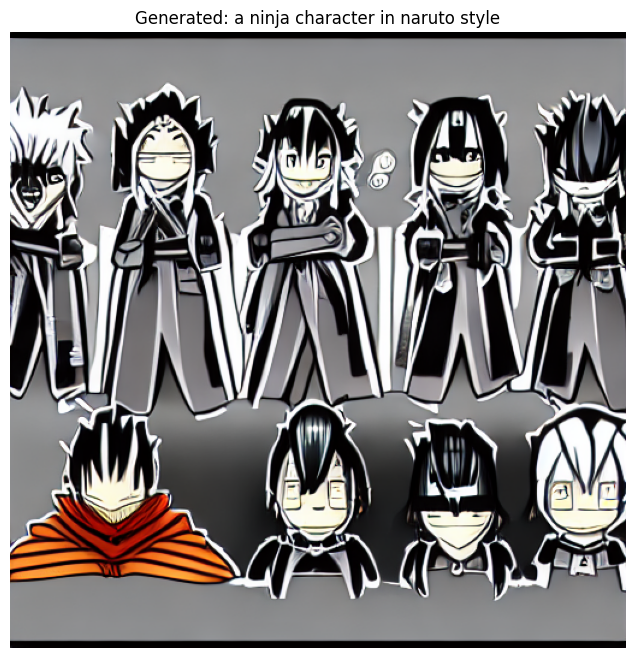

In [17]:
# Test inference with a sample prompt
test_prompt = "a ninja character in naruto style"
test_image = generate_image(test_prompt, seed=42)
plt.figure(figsize=(8, 8))
plt.imshow(test_image)
plt.title(f"Generated: {test_prompt}")
plt.axis('off')
plt.show()

## 8️⃣ Generate Images with Dataset Prompts

**Task**: Generate images using 5 prompts from the training dataset.

**Requirements**:
- Select 5 different text prompts from the dataset
- Generate images for each prompt
- Display results in a grid format
- Show prompt text alongside generated images

In [9]:
dataset_prompts = [
    ds['train'][0]['text'],
    ds['train'][10]['text'],
    ds['train'][20]['text'],
    ds['train'][30]['text'],
    ds['train'][40]['text']
]
dataset_prompts

## 9️⃣ Generate Images with Custom Prompts

**Task**: Generate images using 5 custom prompts that you create.

**Requirements**:
- Write 5 creative prompts in Naruto style
- Test different types of descriptions (characters, scenes, actions)
- Generate and display results
- Compare quality with dataset prompt results

In [10]:
# Define 5 custom prompts in Naruto style
custom_prompts = [
    "a powerful ninja with orange hair performing jutsu in naruto anime style",
    "a beautiful kunoichi with pink hair in traditional ninja outfit, naruto style",
    "a mysterious masked ninja with dark powers, naruto anime art style",
    "a young ninja student practicing with shuriken in Hidden Leaf Village",
    "an epic battle scene between two ninjas with chakra energy, naruto style"
]
custom_prompts

In [ ]:
# Combine all prompts
all_prompts = dataset_prompts + custom_prompts
prompt_labels = ["Dataset"] * 5 + ["Custom"] * 5

# Generate images for all prompts
generated_images = []
for i, prompt in enumerate(all_prompts):
    print(f"Generating image {i+1}/10: {prompt[:50]}...")
    image = generate_image(prompt, seed=42+i)
    generated_images.append(image)

In [ ]:
# Display all 10 generated images with their prompts
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Generated Naruto-Style Images", fontsize=16)

for i, (image, prompt, label) in enumerate(zip(generated_images, all_prompts, prompt_labels)):
    row = i // 5
    col = i % 5

    axes[row, col].imshow(image)
    axes[row, col].set_title(f"{label}: {prompt[:30]}...", fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## 🔟 Model Evaluation and Comparison

**Task**: Evaluate and compare your results

**Requirements**:
- Compare generated images with original dataset images
- Evaluate image quality, style consistency, and prompt adherence
- Discuss training progress and loss convergence
- Document any interesting observations

In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Dataset Images vs Generated Images", fontsize=16)

# Show original dataset images in first row
for i in range(5):
    original_image = ds['train'][i*10]['image']
    axes[0, i].imshow(original_image)
    axes[0, i].set_title(f"Original: {ds['train'][i*10]['text'][:30]}...", fontsize=10)
    axes[0, i].axis('off')

# Show generated images in second row
for i in range(5):
    axes[1, i].imshow(generated_images[i])
    axes[1, i].set_title(f"Generated: {dataset_prompts[i][:30]}...", fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(losses) + 1), losses, 'b-', linewidth=2, marker='o')
plt.title('Training Loss Progression', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print(f"Final training loss: {losses[-1]:.4f}")

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (40%)**
   - Proper stable diffusion pipeline setup
   - Correct training loop implementation
   - Working inference pipeline
   - Appropriate use of VAE, UNet, text encoder, and scheduler

2. **Training and Results (30%)**
   - Model trains without errors
   - Reasonable loss convergence
   - Generated images show Naruto style characteristics
   - Successful generation from both dataset and custom prompts

3. **Code Quality (30%)**
   - Clean, readable code with proper comments
   - Efficient memory usage and error handling
   - Proper tensor operations and device management
   - Good visualization and presentation